In [33]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow import keras

import numpy as np
import collections
import pandas as pd

import matplotlib.pyplot as plt

import pickle
import glob
import re
import os

from tqdm import tqdm
from scipy.optimize import curve_fit

# Upload test dataset

In [14]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

## File lists

In [15]:
data_path    = "../../juno_data/data/projections/test/e+_1/"
target_path  = "../../juno_data/data/real/test/targets/e+_1/"
data_files   = os.listdir(data_path) 
target_files = os.listdir(target_path) 

test_proj    = [file for file in data_files    if "proj" in file]
test_target  = [file for file in target_files  if "targets" in file]

test_proj.sort(key=natural_keys)   
test_target.sort(key=natural_keys) 

In [18]:
test_proj   = test_proj[:50]
test_target = test_target[:50]

## Load test images

In [26]:
#test_images = np.empty(shape=(0, 230, 124, 2))

test_images = np.concatenate([np.load(data_path + file)["arr_0"] for file in tqdm(test_proj)])

#for file in tqdm(test_proj):
#    f   = np.load(data_path + file)["arr_0"]
#    test_images = np.concatenate((test_images, f), axis=0)
    

# nan to zero 
test_images[np.isnan(test_images)] = 0

test_images.shape

100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:43<00:00,  5.68s/it]


(50000, 230, 124, 2)

## Load test targets

In [27]:
#test_labels = np.empty(shape=(0))

test_labels = np.concatenate([pd.read_csv(target_path + file)["edep"].to_numpy() for file in tqdm(test_target)])

#for file in tqdm(test_target):
#    f   = pd.read_csv(target_path + file)["edep"].to_numpy()
#    test_labels = np.concatenate((test_labels, f), axis=0)
    
test_labels.shape

100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 60.53it/s]


(50000,)

# Adaptive LR object

In [28]:
#******CUSTOM LEARNING RATE******#
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, initial_learning_rate, epochs, steps_per_epoch):
    self.initial_learning_rate = initial_learning_rate
    self.epochs = epochs
    self.steps_per_epoch = steps_per_epoch
    self.m = initial_learning_rate / steps_per_epoch
    self.decay_rate = tf.constant((10**-8 / initial_learning_rate)**(((epochs - 1)*steps_per_epoch)**-1), dtype=tf.float32)
    print('decay_rate:', self.decay_rate)

  def __call__(self, step):
    result = tf.cond(tf.less(step, self.steps_per_epoch), 
                   lambda: self.m * (step+1),
                   lambda: self.initial_learning_rate * self.decay_rate**tf.cast(step+1-self.steps_per_epoch, dtype=tf.float32))

    tf.print('lr at step', step, 'is', result, output_stream='file://learning_rates.txt')
    return result  

  def get_config(self):
      return {
          "initial_learning_rate": self.initial_learning_rate,
          "epochs": self.epochs,
          "steps_per_epoch": self.steps_per_epoch
      }

## Load ResNet model

In [29]:
resnet_model = tf.keras.models.load_model("./models/20220603-161936/", custom_objects={'MyLRSchedule': MyLRSchedule})

decay_rate: tf.Tensor(0.9999085, shape=(), dtype=float32)


# PREDICTION

In [ ]:
# make predicitons
edep_pred = resnet_model.predict(test_images, verbose=0)
edep_pred = edep_pred.reshape(edep_pred.shape[0],)
edep_pred.shape

In [31]:
# 3sigma cut
res = (edep_pred-test_labels)/test_labels
res = res[np.abs(res - res.mean()) < 3*res.std()]

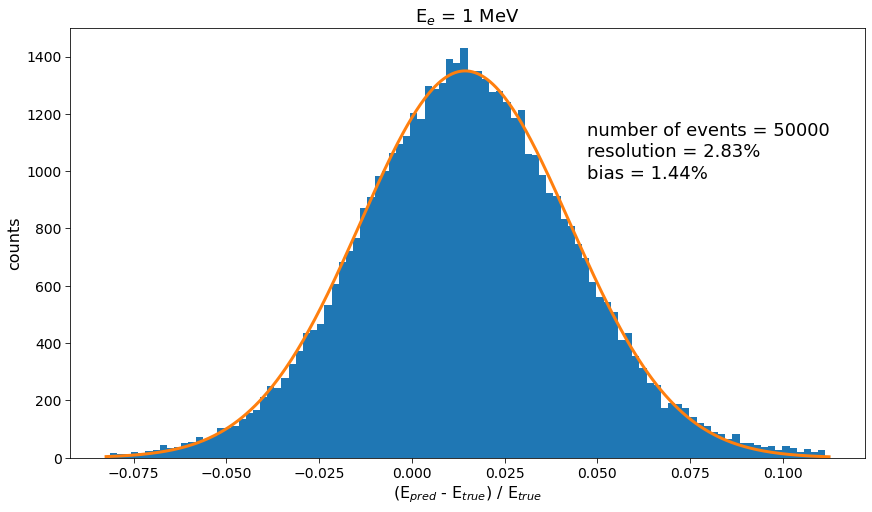

In [36]:
def gaus(x, a, mu, sigma):
    return a*np.exp( -(x-mu)**2 / (2*sigma**2) )

hist, edges = np.histogram(res, bins=100)
bincenters = (edges[1:] + edges[:-1]) / 2

xgrid = np.linspace(edges[0], edges[-1], 500)

n     = res.shape[0]
mean  = res.mean()
sigma = res.std()
popt, pcov = curve_fit(gaus, bincenters, hist, p0=[n, mean, sigma])

n_events   = edep_pred.shape[0]
resolution = popt[2]
bias       = popt[1]

fig = plt.figure(figsize=(12,7), constrained_layout=True)
ax  = fig.add_subplot(111)

ax.hist(bincenters, weights=hist, bins=100)
ax.plot(xgrid, gaus(xgrid, *popt), lw=3)
ax.text(0.65, 0.75, f"number of events = {n_events}", fontsize=18,transform=ax.transAxes)
ax.text(0.65, 0.7, f"resolution = {resolution*100:.2f}%", fontsize=18,transform=ax.transAxes)
ax.text(0.65, 0.65, f"bias = {abs(bias)*100:.2f}%", fontsize=18,transform=ax.transAxes)

ax.set_title("E$_e$ = 1 MeV", fontsize=18)
ax.set_xlabel("(E$_{pred}$ - E$_{true}$) / E$_{true}$", fontsize=16)
ax.set_ylabel("counts", fontsize=16)


# ax.set_yscale("log")

ax.tick_params(axis="both", which="major", labelsize=14, length=5)

fig.savefig("./plots/e_1mev_hist_resnet115.png", dpi=300, facecolor="white")

plt.show()